In [46]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import interpolate

pole = 1.0
beta = 10.0

iwn = lambda n: 1J*(2*n+1)*np.pi/beta
gtau = lambda tau: -np.exp(- tau * pole)/(1 + np.exp(-beta*pole))
giwn = lambda n: 1/(iwn(n) - pole)

# データをスプライン補間した上で、高周波数テールを見積もる
詳しくは、E. Gullの博士論文B.1章を参照のこと
http://hdl.handle.net/20.500.11850/104013

In [62]:
def to_freq_fermionic_real_field(beta,n_freq,f_tau):
    ndiv_tau_smpl = len(f_tau)-1
    n_tau_dense = 2*n_freq
    tau_mesh=np.linspace(0,beta,ndiv_tau_smpl+1)
    tau_mesh_dense=np.linspace(0,beta,n_tau_dense+1)
    freq_mesh=np.linspace(np.pi/beta, (2*n_freq-1)*np.pi/beta, n_freq)
    f_freq = np.zeros(n_freq,dtype=complex)

    #Spline interpolation to evaluate the high-frequency tail
    fit = interpolate.InterpolatedUnivariateSpline(tau_mesh,f_tau)
    deriv_0 = fit.derivatives(0.0)
    deriv_beta = fit.derivatives(beta)
    c1 = -deriv_beta[0]-deriv_0[0]
    c2 = deriv_beta[1]+deriv_0[1]
    c3 = -deriv_beta[2]-deriv_0[2]
    for im in range(0,n_freq):
        f_freq[im]=c1/(1J*freq_mesh[im])+c2/(1J*freq_mesh[im])**2+c3/(1J*freq_mesh[im])**3

    #Contribution from the rest part
    f_tau_rest_dense = fit(tau_mesh_dense)-c1*f_tau_tail_fermionic(beta,n_tau_dense,1)-c2*f_tau_tail_fermionic(beta,n_tau_dense,2)-c3*f_tau_tail_fermionic(beta,n_tau_dense,3)
    for im in range(n_freq):
        ftmp=f_tau_rest_dense*np.exp(1J*freq_mesh[im]*tau_mesh_dense[:])
        f_freq[im]+=np.trapz(ftmp,tau_mesh_dense)

    return f_freq

# Utility functions for FT_to_n_fermionic_real_field
#  This returns the Fourier transform of 1/(i omega_m).
def f_tau_tail_fermionic(beta,ndiv_tau,m):
    tau_mesh=np.linspace(0,beta,ndiv_tau+1)
    if m==1:
        tau_mesh[:] = -0.5
        return tau_mesh
    elif m==2:
        return 0.25*(-beta+2*tau_mesh)
    elif m==3:
        return 0.25*(beta*tau_mesh-tau_mesh**2)
    else:
        raise RuntimeError("Error: m=" + str(m))

In [63]:
ntau = 1000
nfreq = 1000
taus = np.linspace(0, beta, ntau)
gtau_data = np.array([gtau(tau) for tau in taus])
giwn_data = to_freq_fermionic_real_field(beta, nfreq, gtau_data)

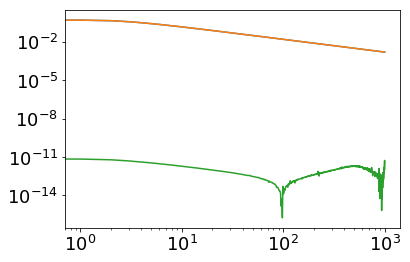

In [64]:
nvec = np.arange(0, nfreq)
giwn_ref = np.array([giwn(n) for n in nvec])
plt.plot(nvec, -giwn_data.imag)
plt.plot(nvec, -giwn_ref.imag)
plt.plot(nvec, np.abs(-giwn_ref.imag +giwn_data.imag) )
plt.xscale("log")
plt.yscale("log")